In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import librosa.display
import scipy.io.wavfile
from scipy.signal.windows import hamming

In [2]:
sample_rate, signal = scipy.io.wavfile.read("../../data/samples/akshay_khanna.wav")

In [3]:
sample_rate

16000

In [4]:
signal = signal[:int(sample_rate * 3)].astype('float32')

In [5]:
signal.shape

(48000,)

In [6]:
def plot_signal(signal):
    """
    Utility Function for plotting speech signal
    """
    plt.rcParams["figure.figsize"] = (20, 3)
    plt.plot(signal)
    plt.xlabel("time")
    plt.ylabel("amplitude")
    plt.show()

def plot_spect(spect, power=1):
    """
    Utility Function for plotting Spectrogram features
    """
    plt.rcParams["figure.figsize"] = (5, 5)
    librosa.display.specshow(spect, x_axis='time')
    plt.axis('off')
    if power == 1:
        plt.title("Energy Spectrogram of dimensions: {}".format(spect.shape))
    else:
        plt.title("Power Spectrogram of dimensions: {}".format(spect.shape))
    plt.show()
    
def plot_mfcc(mfcc):
    """
    Utility Function for plotting MFCC features
    """
    plt.rcParams["figure.figsize"] = (5, 5)
    librosa.display.specshow(mfcc, x_axis='time')
    plt.title("MFCC features of dimensions: {}".format(mfcc.shape))
    plt.show()

In [7]:
def normalize_features(x):
    """
    Performs Mean and Variance Normalization across all frequency bins
    """
    mu = x.mean(axis=1)
    std = x.std(axis=1)
    mu = mu.reshape(mu.shape[0], 1)
    std = std.reshape(std.shape[0], 1)
    
    x = x - mu
    x = x / (std + 1e-7)
    return x

In [8]:
# plot_spect(normalize_features(energy_spect))

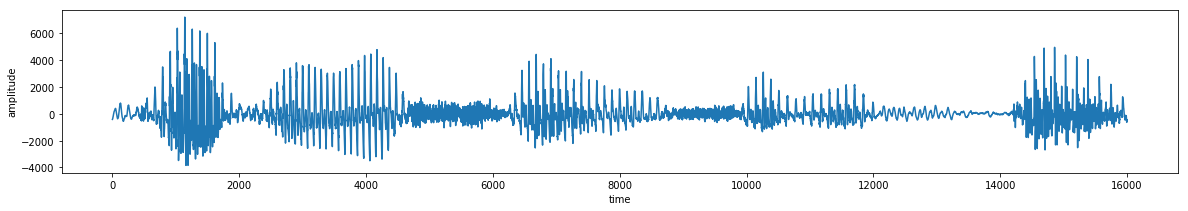

In [10]:
plot_signal(signal[16000:32000])


## Step 1: Pre-emphasis Filter and Windowing
### Pre-emphasis
Used to
1. balance the frequency spectrum since high frequencies usually have smaller magnitudes compared to lower frequencies
2. Improve SNR
3. Avoid Numerical Problems
 
 Pre-emphasis filter can be defined as:
                                    $y(t)=x(t)−αx(t−1)$
 where $α$ is the pre-emphasis coefficent (usually $=0.97$)
 
-> These days, it's rarely applied, since we are going to mean-normalize the features anyway

In [11]:
pre_emphasis = 0.97
emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

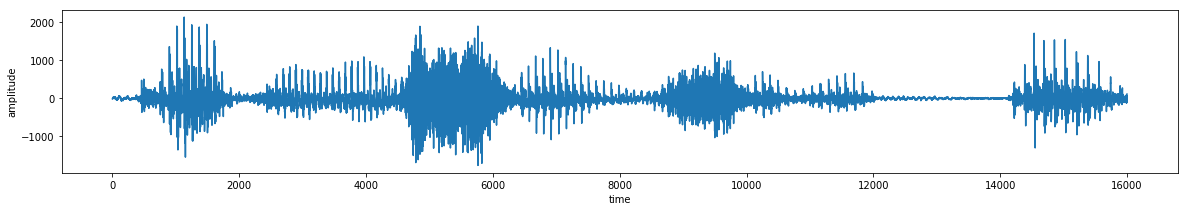

In [13]:
plot_signal(emphasized_signal[16000:32000])

## Spectrograms

### Step 1. Windowing and N-point FFT
#### Windowing
We apply window function on each frame, such as the Hamming window
Why?
To counteract the assumption made by FFT that the data is infinite

#### FFT
This is followed by an N-Point FFT over each frame, which is also called
Short Term Fourier Transform (STFT). 

We utilize librosa's stft function that does Framing + windowing + N-point FFT for us



In [14]:
frame_size, frame_stride = 0.02, 0.01

In [15]:
n_fft, win_len, hop_len = 512, int(frame_size * sample_rate), int(frame_stride * sample_rate)
n_fft, win_len, hop_len

(512, 320, 160)

In [16]:
D = librosa.stft(emphasized_signal, n_fft=n_fft, hop_length=hop_len,
                 win_length=n_fft, window=hamming)

D is an array of complex number. We'll separate the magnitude and phase information from it

In [17]:
D.shape

(257, 301)

In [18]:
D

array([[-165.19273  +0.0000000e+00j, -159.41911  +0.0000000e+00j,
          36.677094 +0.0000000e+00j, ...,  153.53145  +0.0000000e+00j,
        -373.5836   +0.0000000e+00j, -918.7088   +0.0000000e+00j],
       [  87.73901  +2.7215153e-01j,  101.87987  -1.9542988e+01j,
         -36.278    +1.8480455e+02j, ...,  -96.756744 -9.8474953e+01j,
         -14.624256 -3.5117297e+02j,  928.367    +1.0768460e+01j],
       [ -86.02364  +1.5112524e-01j,   26.324018 +1.3822748e+02j,
          65.28451  -8.4971466e+01j, ...,  -32.720325 -1.2989165e+02j,
          15.119181 -2.5123170e+02j, -875.7071   -2.2700788e+01j],
       ...,
       [  -6.6349683-9.6017785e-02j,  -15.010437 -1.9402779e+01j,
          19.652966 +8.4991236e+00j, ...,  -17.645761 -2.2124355e+00j,
          -9.780231 -1.0786834e+00j,   -2.6840076+8.4517933e-02j],
       [  -4.594258 -4.1190777e-02j,   17.405737 +4.5678549e+00j,
         -13.912316 -1.6360083e+01j, ...,  -11.645401 +3.6632053e+01j,
          19.478254 +1.1355183e+01j

In [19]:
spect, phase = librosa.magphase(D)


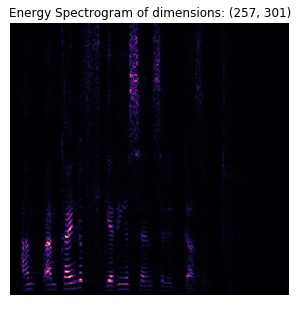

In [20]:
plot_spect(spect)

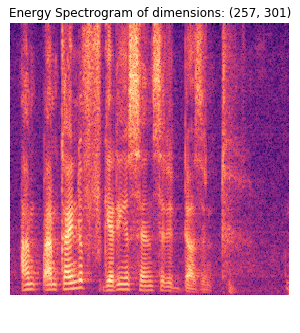

In [21]:
spect = np.log1p(spect)
plot_spect(spect)

Here, this intermediate "spect" is the Spectrogram features we're looking for.
However, they're not ready yet.

### Step 1: Power Spectrogram vs Energy Spectrogram
Depending on the "power" this "spect" is raised to, we obtain different kind of features

if $power=1$ we get Energy Spectrograms

if $power=2$, we get Power Spectrograms

### Step 2: Normalization
Mean and variance normalization across every frequency bin of the spectrogram
(Crucial for better and faster generalization, [3])

In [22]:
# Step 1
power = 1
energy_spect = spect ** power

In [23]:
energy_spect.shape

(257, 301)

In [24]:
energy_spect[:, :5]

array([[5.113148 , 5.07779  , 3.6290524, 5.031195 , 4.274309 ],
       [4.4857044, 4.651456 , 5.2435   , 5.2139444, 4.7663937],
       [4.4661813, 4.953795 , 4.6835666, 4.932982 , 2.9842243],
       ...,
       [2.0328298, 3.2399023, 3.109597 , 2.5530612, 3.3299387],
       [1.7217736, 2.944183 , 3.112434 , 2.3825421, 3.0468748],
       [2.0461433, 2.616031 , 2.218915 , 2.777555 , 1.5513479]],
      dtype=float32)

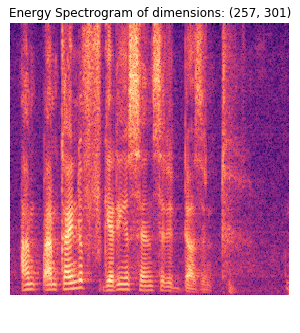

In [25]:
plot_spect(energy_spect)

In [26]:
# Step 2
energy_spect = normalize_features(energy_spect)

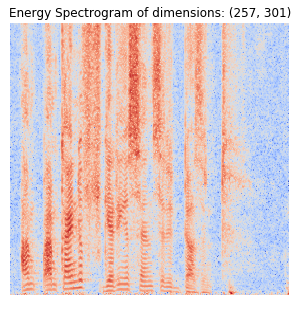

In [27]:
plot_spect(energy_spect)

In [44]:
power = 2
power_spect = spect ** power

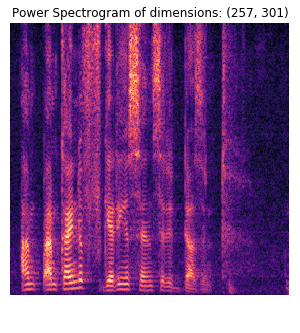

In [45]:
plot_spect(power_spect, 2)

In [46]:
power_spect = normalize_features(power_spect)

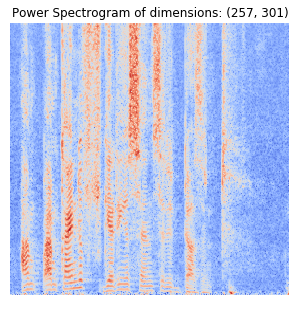

In [47]:
plot_spect(power_spect, 2)

### MFCCs
#### Step 1: convert energy_spec above to mel scale, using the formula
$M(f) = 1124 \ln(1 + f/700)$
#### Step 2: Apply DCT on the output of step 1, to get MFCCs

We're gonna simply use librosa's implementation

#### Step 3: Per Frequency bin Normalization

In [28]:
mfcc = librosa.feature.mfcc(y=emphasized_signal, sr=sample_rate, n_fft=n_fft, n_mels=40)

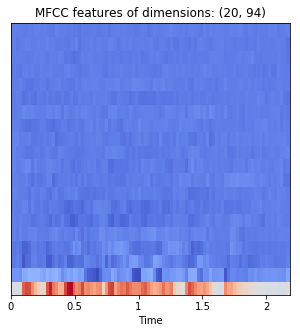

In [29]:
plot_mfcc(mfcc)

In [30]:
mfcc = normalize_features(mfcc)

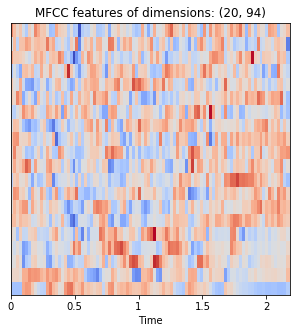

In [31]:
plot_mfcc(mfcc)

### References
[1] A. Nagrani, J. S. Chung, and A. Zisserman, “Voxceleb: A large-scale speaker identification dataset,” in Proc. Interspeech 2017, 2017, pp. 2616–2620. [Online]. Available: http://dx.doi.org/10.21437/Interspeech.2017-950